In [1]:
import numpy as np
np.random.seed(1)
import cv2 as cv # only to compare and validate

import skimage
from skimage.util import view_as_windows
from skimage import io, color, filters
from scipy.ndimage import gaussian_filter, maximum_filter

from scipy.signal import convolve2d
from scipy.ndimage import maximum_filter # different than max pooling
import os
from sympy.utilities.iterables import multiset_permutations # gives all permuations

import matplotlib.pyplot as plt

from tqdm import tqdm
import networkx as nx



In [2]:
# from the classes we made
from utils.harris_detector import Transformations, HarrisDetector
from utils.loading_images import SingleImages, PairWise

In [3]:
pi = PairWise()
si = SingleImages(generate_crops=False)
hd = HarrisDetector()

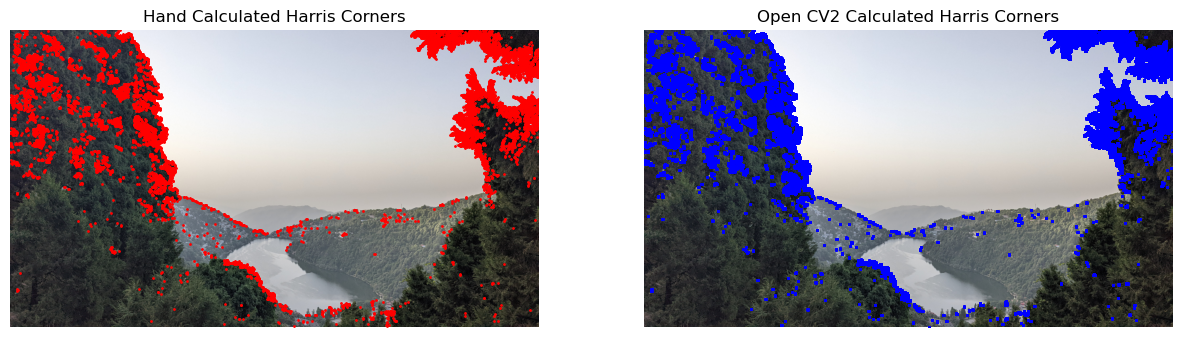

In [4]:
hd.compare_opencv(pi.pond[0])

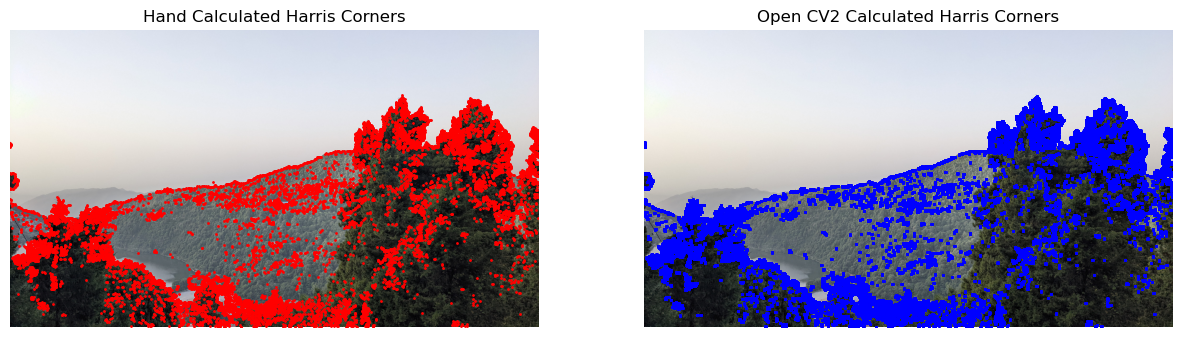

In [5]:
hd.compare_opencv(pi.pond[1])

In [6]:
def try_stitch(img1,img2):
    """
    Janky method..
    """
    # Initialize SIFT detector
    sift = cv.SIFT_create()

    # Find keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

        # FLANN parameters setup
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # Increase this for more precision, decrease for speed

    # Create the FLANN object
    flann = cv.FlannBasedMatcher(index_params, search_params)

    # Matching descriptors
    matches = flann.knnMatch(descriptors1.astype(np.float32), descriptors2.astype(np.float32), k=2)

    # Need to store good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Compute the homography matrix
    h, mask = cv.findHomography(points1, points2, cv.RANSAC)

    # Dimensions of the result
    height, width, channels = img2.shape

    # Warp the first image using the homography matrix
    warped_image = cv.warpPerspective(img1, h, (width * 2, height))
    warped_image[0:height, 0:width] = img2
    return warped_image

In [ ]:
w = try_stitch(pi.himalyan[1],pi.himalyan[0])
si.plot_image(w)

In [ ]:
pi.plot_pair(1)

In [ ]:
w = try_stitch(pi.mountain[1],pi.mountain[0])
si.plot_image(w)

In [ ]:
pi.plot_pair(2)

In [ ]:
class ImageStitcher:
    def __init__(self):
        self.sift = cv.SIFT_create()
        # if we want to filter harris corners -> descriptors (poor performance .. does not work well even with slightly rotated images)
        self.harris = None # optionally pass in the harris corners
        
    def print_help(self):
        help_text = """
        Please pass in the input image as [img_left, img_right]
        DOES NOT accomodate > 2 inputs or vertical panorama
        """

    def detect_features(self, images):
        keypoints_list = []
        descriptors_list = []
        for image in images:
            keypoints, descriptors = self.sift.detectAndCompute(image, None)
            keypoints_list.append(keypoints)
            descriptors_list.append(descriptors)
        return keypoints_list, descriptors_list

    def match_features(self, descriptors_list):
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = []
        num_images = len(descriptors_list)
        for i in range(num_images):
            for j in range(i + 1, num_images):
                match = flann.knnMatch(descriptors_list[i].astype(np.float32), descriptors_list[j].astype(np.float32), k=2)
                good_matches = [m for m, n in match if m.distance < 0.75 * n.distance]
                if good_matches:
                    matches.append((i, j, good_matches))
        return matches

    def construct_graph(self, matches):
        G = nx.Graph()
        for i, j, good_matches in matches:
            G.add_edge(i, j, weight=len(good_matches))
        return G

    def find_best_base_image(self, G):
        # Determine the best base image as the one with the highest degree of connectivity
        degrees = dict(G.degree(weight='weight'))
        return max(degrees, key=degrees.get)

    def compute_homographies(self, keypoints_list, matches):
        homographies = {}
        for i, j, good_matches in tqdm(matches):
            points1 = np.array([keypoints_list[i][m.queryIdx].pt for m in good_matches], dtype=np.float32)
            points2 = np.array([keypoints_list[j][m.trainIdx].pt for m in good_matches], dtype=np.float32)
            h, _ = cv.findHomography(points2, points1, cv.RANSAC)
            homographies[(j, i)] = h
        return homographies

    def stitch(self, images):
        keypoints_list, descriptors_list = self.detect_features(images)
        matches = self.match_features(descriptors_list)
        G = self.construct_graph(matches)
        base_idx = self.find_best_base_image(G)
        homographies = self.compute_homographies(keypoints_list, matches)

        # Start stitching from the base image
        base_image = images[base_idx]
        height, width = base_image.shape[:2]
        panorama = np.zeros((height, width * len(images), 3), dtype=np.uint8)
        panorama[:height, :width] = base_image

        for i in range(len(images)):
            if i == base_idx:
                continue
            h = homographies.get((i, base_idx))
            if h is not None:
                warped_image = cv.warpPerspective(images[i], h, (width * len(images), height))
                panorama = np.where(panorama == 0, warped_image, panorama)

        return panorama


In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

class ImageStitcher:
    def __init__(self):
        self.sift = cv.SIFT_create()

    def detect_features(self, images):
        keypoints_list = []
        descriptors_list = []
        for image in images:
            gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            keypoints, descriptors = self.sift.detectAndCompute(gray, None)
            keypoints_list.append(keypoints)
            descriptors_list.append(descriptors)
        return keypoints_list, descriptors_list

    def match_features(self, descriptors_list):
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches_info = []
        num_images = len(descriptors_list)
        for i in range(num_images):
            for j in range(i + 1, num_images):
                matches = flann.knnMatch(descriptors_list[i].astype(np.float32), descriptors_list[j].astype(np.float32), k=2)
                good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
                if good_matches:
                    matches_info.append((i, j, good_matches))
        return matches_info

    def plot_matches(self, img1, img2, kp1, kp2, matches):
        # Draw matches between two images
        img_matches = cv.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(12, 6))
        plt.imshow(img_matches)
        plt.title('Matches')
        plt.show()

    def stitch(self, images):
        keypoints_list, descriptors_list = self.detect_features(images)
        matches_info = self.match_features(descriptors_list)

        # Optionally plot matches for the first pair found (for demonstration)
        if matches_info:
            i, j, good_matches = matches_info[0]  # Plot matches for the first pair
            self.plot_matches(images[i], images[j], keypoints_list[i], keypoints_list[j], good_matches)

        # Stitching logic continues here...
        # This is where you would continue to stitch images based on found matches
        # and homographies computed from these matches.

        return images[0]  # Placeholder to return the first image for now



In [ ]:
class ImageStitcher:
    def __init__(self):
        self.print_help()
        self.sift = cv.SIFT_create()

    def print_help(self):
        help_text = """
        pass in the input in any order (left_image, right_image) : we make 2 attempts
        Does not accomodate >2 Multiple inputs require identifying base image
        """
        print(help_text)

    def detect_features(self, images):
        keypoints_list = []
        descriptors_list = []
        for image in images:
            keypoints, descriptors = self.sift.detectAndCompute(image, None)
            keypoints_list.append(keypoints)
            descriptors_list.append(descriptors)
        return keypoints_list, descriptors_list

    def match_features(self, descriptors_list):
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = []
        num_images = len(descriptors_list)
        for i in range(num_images):
            for j in range(i + 1, num_images):
                match = flann.knnMatch(descriptors_list[i].astype(np.float32), descriptors_list[j].astype(np.float32), k=2)
                good_matches = [m for m, n in match if m.distance < 0.75 * n.distance]
                if good_matches:
                    matches.append((i, j, good_matches))
        return matches

    # self made ransac implementation :: refernce : https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
    def ransac_homography(self, keypoints1, keypoints2, good_matches, max_iters=1000, threshold=5.0):
        points1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches], dtype=np.float32)
        points2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches], dtype=np.float32)
        max_inliers_count = 0
        best_h = None
        best_inliers = []

        for _ in tqdm(range(max_iters)):
            if len(points1) < 4:
                continue
            indices = np.random.choice(len(points1), 4, replace=False)
            src_pts = points1[indices]
            dst_pts = points2[indices]
            h, _ = cv.findHomography(src_pts, dst_pts, 0)
            projected_pts = cv.perspectiveTransform(points1.reshape(-1, 1, 2), h)
            errors = np.linalg.norm(projected_pts.squeeze() - points2, axis=1)
            inliers = errors < threshold
            inlier_count = np.sum(inliers)
            if inlier_count > max_inliers_count:
                max_inliers_count = inlier_count
                best_h = h
                best_inliers = inliers

        if best_h is not None and max_inliers_count > 4:
            inlier_src_pts = points1[best_inliers]
            inlier_dst_pts = points2[best_inliers]
            best_h, _ = cv.findHomography(inlier_src_pts, inlier_dst_pts, cv.RANSAC)
        return best_h, best_inliers

    def attach(self, images):
        keypoints_list, descriptors_list = self.detect_features(images)
        matches = self.match_features(descriptors_list)
        stitched_image = images[0]  # Start with the first image as the base
        for i, j, good_matches in matches:
            h, _ = self.ransac_homography(keypoints_list[i], keypoints_list[j], good_matches)
            if h is not None:
                height, width, _ = images[j].shape
                stitched_image = cv.warpPerspective(stitched_image, h, (width * 2, height))
                stitched_image[0:height, 0:width] = images[j]

        return stitched_image

    def stitch(self,images):
        # sometimes the reversed order works better
        attempt1 = self.attach(images)
        attempt2 = self.attach(images[::-1])
        # the failed attempt it would have mostly black pixels.
        # return back the one with the higher sum
        if attempt1.sum() > attempt2.sum():
            return attempt1
        return attempt2

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

class ImageStitcher:
    def __init__(self):
        self.print_help()
        self.sift = cv.SIFT_create()

    def print_help(self):
        help_text = """
        pass in the input in any order (left_image, right_image): we make 2 attempts
        Does not accommodate >2 images
        Does not accomodate vertical panorama
        """
        print(help_text)

    def detect_features(self, images):
        keypoints_list = []
        descriptors_list = []
        for image in images:
            keypoints, descriptors = self.sift.detectAndCompute(image, None)
            keypoints_list.append(keypoints)
            descriptors_list.append(descriptors)
        return keypoints_list, descriptors_list

    def match_features(self, descriptors_list):
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = []
        num_images = len(descriptors_list)
        for i in range(num_images):
            for j in range(i + 1, num_images):
                match = flann.knnMatch(descriptors_list[i].astype(np.float32), descriptors_list[j].astype(np.float32), k=2)
                good_matches = [m for m, n in match if m.distance < 0.75 * n.distance]
                if good_matches:
                    matches.append((i, j, good_matches))
        return matches

    def plot_matches(self, img1, img2, kp1, kp2, matches):
        # Create an image that shows matching keypoints between two images
        match_img = cv.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(12, 6))
        plt.imshow(cv.cvtColor(match_img, cv.COLOR_BGR2RGB))  # Convert to RGB for plotting
        plt.title("Matched Features")
        plt.axis('off')
        plt.show()

    def ransac_homography(self, keypoints1, keypoints2, good_matches, max_iters=1000, threshold=5.0):
        points1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches], dtype=np.float32)
        points2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches], dtype=np.float32)
        max_inliers_count = 0
        best_h = None
        best_inliers = []

        for _ in tqdm(range(max_iters)):
            if len(points1) < 4:
                continue
            indices = np.random.choice(len(points1), 4, replace=False)
            src_pts = points1[indices]
            dst_pts = points2[indices]
            h, _ = cv.findHomography(src_pts, dst_pts, 0)
            projected_pts = cv.perspectiveTransform(points1.reshape(-1, 1, 2), h)
            errors = np.linalg.norm(projected_pts.squeeze() - points2, axis=1)
            inliers = errors < threshold
            inlier_count = np.sum(inliers)
            if inlier_count > max_inliers_count:
                max_inliers_count = inlier_count
                best_h = h
                best_inliers = inliers

        if best_h is not None and max_inliers_count > 4:
            inlier_src_pts = points1[best_inliers]
            inlier_dst_pts = points2[best_inliers]
            best_h, _ = cv.findHomography(inlier_src_pts, inlier_dst_pts, cv.RANSAC)
        return best_h, best_inliers

    def attach(self, images, plot=False):
        keypoints_list, descriptors_list = self.detect_features(images)
        matches = self.match_features(descriptors_list)
        stitched_image = images[0]  # Start with the first image as the base
        for i, j, good_matches in matches:
            h, _ = self.ransac_homography(keypoints_list[i], keypoints_list[j], good_matches)
            if plot:
                self.plot_matches(images[i], images[j], keypoints_list[i], keypoints_list[j], good_matches)
            if h is not None:
                height, width, _ = images[j].shape
                stitched_image = cv.warpPerspective(stitched_image, h, (width * 2, height))
                stitched_image[0:height, 0:width] = images[j]
        return stitched_image

    def stitch(self, images):
        attempt1 = self.attach(images, plot=True)
        attempt2 = self.attach(images[::-1], plot=False)
        if attempt1.sum() > attempt2.sum():
            return attempt1
        else:
            return attempt2


In [ ]:
pi = PairWise()
pi.plot_pair(2)

In [ ]:
s = ImageStitcher()
w = s.stitch(pi.mountain) # 5_671_883_469 , 3_723_096_826
si.plot_image(w)

In [ ]:
pi.plot_pair(1)

In [ ]:
s = ImageStitcher()
w = s.stitch(pi.himalyan)
si.plot_image(w)

In [ ]:
w = s.stitch(pi.pond)
si.plot_image(w)

In [ ]:
# example that will show how our code does not accomodate
# stitching should happen from the middle instead
pi.plot_pair(0)

In [ ]:
si = SingleImages(generate_crops=True,crop_ratio=0.2,random_rotate=True,num_horizontal_splits=2,num_vertical_splits=1)

In [ ]:
imgs = si.crops[0]
si.plot_crops(imgs)

In [ ]:
w = s.stitch(imgs)
si.plot_image(w)

In [ ]:
imgs = si.crops[1]
si.plot_crops(imgs)

In [ ]:
w = s.stitch(imgs)
si.plot_image(w)

In [ ]:
imgs = si.crops[2]
si.plot_crops(imgs)

In [ ]:
w = s.stitch(imgs)
si.plot_image(w)